In [1]:
import tensorflow as tf

import numpy as np

import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

In [2]:
# Use your own path ;)
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Rescale the images from [0,255] to the [0.0,1.0] range.
x_train, x_test = x_train/255.0, x_test/255.0

# Add a channels dimension
x_train = x_train[..., tf.newaxis].astype("float32")
x_test = x_test[..., tf.newaxis].astype("float32")

In [3]:
print(x_train.shape)
print(y_train.shape)

(60000, 28, 28, 1)
(60000,)


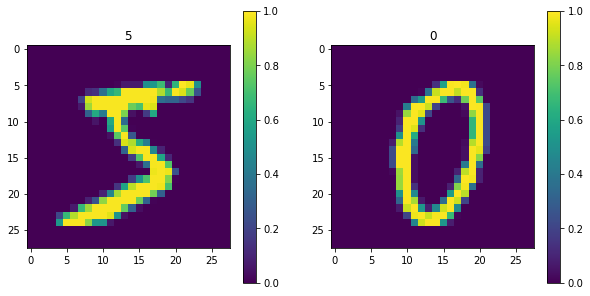

In [4]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(x_train[0])
plt.colorbar()
plt.title(y_train[0].item());
plt.subplot(1,2,2)
plt.imshow(x_train[1000])
plt.colorbar()
plt.title(y_train[1000].item());

In [5]:
train_ds = tf.data.Dataset.from_tensor_slices(
    (x_train, y_train)).shuffle(10000).batch(32)

test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(32)

# Tasks
* Train a classifier with fully-connected layers only.
* Train a classifier with convolutions only.
* Train a classifier with convolutions and fully-connected layers.
* Train a denoising network. Note, you have to create some noisy observations first ;)

# 1. Create model

Helpful: https://www.tensorflow.org/guide/keras/custom_layers_and_models

# 3. Choose loss-function and optimizer

# 4. Write train-loop

__Note:__ This time we did not set the environment variable to hide the GPU. Hence, if you have access to a GPU the model will automatically run on GPU.

__PS:__ Don't forget `@tf.function` to speed-up training!

In [6]:
class MyModel_FullyDense(tf.keras.Model):
    def __init__(self):
        super(MyModel_FullyDense, self).__init__()
        
        self.flat_input = tf.keras.layers.Flatten()
        self.dense = tf.keras.layers.Dense(32, activation='relu')
        self.output_tensor = tf.keras.layers.Dense(10, activation='softmax')
        
        self.loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
        self.optimizer = tf.keras.optimizers.Adam()

        self.train_loss = tf.keras.metrics.Mean(name='train_loss')
        self.train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

        self.test_loss = tf.keras.metrics.Mean(name='test_loss')
        self.test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

    def call(self, x):
        x = self.flat_input(x)
        x = self.dense(x)
        return self.output_tensor(x)
    
    @tf.function
    def test_step(self, images, labels):
        predictions = self(images, training=False)
        t_loss = self.loss_object(labels, predictions)

        self.test_loss(t_loss)
        self.test_accuracy(labels, predictions)
        
    @tf.function
    def train_step(self, images, labels):
        with tf.GradientTape() as tape:
            predictions = self(images, training=True)
            loss = self.loss_object(labels, predictions)
        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

        self.train_loss(loss)
        self.train_accuracy(labels, predictions)
        
    def train(self, train_ds, EPOCHS = 5):
        for epoch in range(EPOCHS):
            # Reset the metrics at the start of the next epoch
            self.train_loss.reset_states()
            self.train_accuracy.reset_states()
            self.test_loss.reset_states()
            self.test_accuracy.reset_states()

            for images, labels in train_ds:
                self.train_step(images, labels)

            for test_images, test_labels in test_ds:
                self.test_step(test_images, test_labels)

            print( 'Epoch %d, Loss: %.3f, Accuracy: %.2f%%, Test Loss: %.3f, Test Accuracy: %.2f%%'%(
                epoch+1, self.train_loss.result(), self.train_accuracy.result() * 100, self.test_loss.result(), self.test_accuracy.result() * 100
            ))

In [94]:
class MyModel_FullyConv(tf.keras.Model):
    def __init__(self):
        super(MyModel_FullyConv, self).__init__()
        
        self.conv1 = tf.keras.layers.Conv2D(filters=1,  kernel_size=3, strides=1, activation='relu') #28-2    = 26
        self.conv2 = tf.keras.layers.Conv2D(filters=10, kernel_size=3, strides=1, activation='relu') # -2,    = 24
        self.pool1 = tf.keras.layers.MaxPooling2D(pool_size=2, strides=2)                            # /2     = 12
        self.conv3 = tf.keras.layers.Conv2D(filters=10, kernel_size=3, strides=1, activation='relu') # -2     = 10
        # - - - - - - - - - 
        self.pool2 = tf.keras.layers.MaxPooling2D(pool_size=2, strides=2)                            # /2     = 5
        self.conv4 = tf.keras.layers.Conv2D(filters=10, kernel_size=5, strides=1, activation='relu') # -4     = 1
        self.flat_out = tf.keras.layers.Flatten()
        
        self.loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
        self.optimizer = tf.keras.optimizers.Adam()

        self.train_loss = tf.keras.metrics.Mean(name='train_loss')
        self.train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

        self.test_loss = tf.keras.metrics.Mean(name='test_loss')
        self.test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

    def call(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.pool1(x)
        x = self.conv3(x)
        x = self.pool2(x)
        x = self.conv4(x)
        x = self.flat_out(x)
        return tf.keras.activations.softmax(x)

    @tf.function
    def test_step(self, images, labels):
        predictions = self(images, training=False)
        t_loss = self.loss_object(labels, predictions)

        self.test_loss(t_loss)
        self.test_accuracy(labels, predictions)
        
    @tf.function
    def train_step(self, images, labels):
        with tf.GradientTape() as tape:
            predictions = self(images, training=True)
            loss = self.loss_object(labels, predictions)
        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

        self.train_loss(loss)
        self.train_accuracy(labels, predictions)
        
    def train(self, train_ds, EPOCHS = 5):
        for epoch in range(EPOCHS):
            # Reset the metrics at the start of the next epoch
            self.train_loss.reset_states()
            self.train_accuracy.reset_states()
            self.test_loss.reset_states()
            self.test_accuracy.reset_states()

            for images, labels in train_ds:
                self.train_step(images, labels)

            for test_images, test_labels in test_ds:
                self.test_step(test_images, test_labels)

            print( 'Epoch %d, Loss: %.3f, Accuracy: %.2f%%, Test Loss: %.3f, Test Accuracy: %.2f%%'%(
                epoch+1, self.train_loss.result(), self.train_accuracy.result() * 100, self.test_loss.result(), self.test_accuracy.result() * 100
            ))

In [90]:
class MyModel_Mixed(tf.keras.Model):
    def __init__(self):
        super(MyModel_Mixed, self).__init__()
        
        self.conv1 = tf.keras.layers.Conv2D(filters=1,  kernel_size=3, strides=1, activation='relu') #28-2    = 26
        self.conv2 = tf.keras.layers.Conv2D(filters=10, kernel_size=3, strides=1, activation='relu') # -2,    = 24
        self.pool1 = tf.keras.layers.MaxPooling2D(pool_size=2, strides=2)                            # /2     = 12
        self.conv3 = tf.keras.layers.Conv2D(filters=10, kernel_size=3, strides=1, activation='relu') # -2     = 10
        # - - - - - - - - - 
        self.flatten = tf.keras.layers.Flatten()
        self.d1 = tf.keras.layers.Dense(128, activation='relu')
        self.d2 = tf.keras.layers.Dense(10, activation='softmax')
        
        self.loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
        self.optimizer = tf.keras.optimizers.Adam()

        self.train_loss = tf.keras.metrics.Mean(name='train_loss')
        self.train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

        self.test_loss = tf.keras.metrics.Mean(name='test_loss')
        self.test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

    def call(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.pool1(x)
        x = self.conv3(x)
        x = self.flatten(x)
        x = self.d1(x)
        return self.d2(x)
    
    @tf.function
    def test_step(self, images, labels):
        predictions = self(images, training=False)
        t_loss = self.loss_object(labels, predictions)

        self.test_loss(t_loss)
        self.test_accuracy(labels, predictions)
        
    @tf.function
    def train_step(self, images, labels):
        with tf.GradientTape() as tape:
            predictions = self(images, training=True)
            loss = self.loss_object(labels, predictions)
        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

        self.train_loss(loss)
        self.train_accuracy(labels, predictions)
        
    def train(self, train_ds, EPOCHS = 5):
        for epoch in range(EPOCHS):
            # Reset the metrics at the start of the next epoch
            self.train_loss.reset_states()
            self.train_accuracy.reset_states()
            self.test_loss.reset_states()
            self.test_accuracy.reset_states()

            for images, labels in train_ds:
                self.train_step(images, labels)

            for test_images, test_labels in test_ds:
                self.test_step(test_images, test_labels)

            print( 'Epoch %d, Loss: %.3f, Accuracy: %.2f%%, Test Loss: %.3f, Test Accuracy: %.2f%%'%(
                epoch+1, self.train_loss.result(), self.train_accuracy.result() * 100, self.test_loss.result(), self.test_accuracy.result() * 100
            ))

# 2. Test if model runs

In [9]:
### This shit never worked...
# model.build([784])
# model.summary()

In [10]:
model_fdense = MyModel_FullyDense()
model_fdense.train(train_ds,EPOCHS=5)
model_fdense.summary()

Epoch 1, Loss: 0.351, Accuracy: 90.24%, Test Loss: 0.206, Test Accuracy: 93.76%
Epoch 2, Loss: 0.189, Accuracy: 94.57%, Test Loss: 0.153, Test Accuracy: 95.45%
Epoch 3, Loss: 0.149, Accuracy: 95.71%, Test Loss: 0.138, Test Accuracy: 95.79%
Epoch 4, Loss: 0.126, Accuracy: 96.31%, Test Loss: 0.126, Test Accuracy: 96.13%
Epoch 5, Loss: 0.109, Accuracy: 96.71%, Test Loss: 0.117, Test Accuracy: 96.29%
Model: "my_model__fully_dense"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  25120     
_________________________________________________________________
dense_1 (Dense)              multiple                  330       
Total params: 25,458
Trainable params: 25,450
Non-trainable params: 8
_____________________________________

In [95]:
model_fconv = MyModel_FullyConv()
model_fconv.train(train_ds,EPOCHS=5)
model_fconv.summary()

Epoch 1, Loss: 0.863, Accuracy: 67.97%, Test Loss: 0.770, Test Accuracy: 69.54%
Epoch 2, Loss: 0.653, Accuracy: 73.99%, Test Loss: 0.536, Test Accuracy: 78.58%
Epoch 3, Loss: 0.527, Accuracy: 78.93%, Test Loss: 0.516, Test Accuracy: 78.84%
Epoch 4, Loss: 0.515, Accuracy: 79.12%, Test Loss: 0.510, Test Accuracy: 78.85%
Epoch 5, Loss: 0.508, Accuracy: 79.29%, Test Loss: 0.510, Test Accuracy: 78.85%
Model: "my_model__fully_conv_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_74 (Conv2D)           multiple                  10        
_________________________________________________________________
conv2d_75 (Conv2D)           multiple                  100       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 multiple                  0         
_________________________________________________________________
conv2d_76 (Conv2D)           multiple   

In [91]:
model_mixed = MyModel_Mixed()
model_mixed.train(train_ds,EPOCHS=5)
model_mixed.summary()

Epoch 1, Loss: 0.200, Accuracy: 93.86%, Test Loss: 0.065, Test Accuracy: 97.85%
Epoch 2, Loss: 0.064, Accuracy: 98.00%, Test Loss: 0.064, Test Accuracy: 97.57%
Epoch 3, Loss: 0.043, Accuracy: 98.60%, Test Loss: 0.039, Test Accuracy: 98.47%
Epoch 4, Loss: 0.033, Accuracy: 98.93%, Test Loss: 0.042, Test Accuracy: 98.58%
Epoch 5, Loss: 0.024, Accuracy: 99.24%, Test Loss: 0.061, Test Accuracy: 98.02%
Model: "my_model__mixed_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_71 (Conv2D)           multiple                  10        
_________________________________________________________________
conv2d_72 (Conv2D)           multiple                  100       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 multiple                  0         
_________________________________________________________________
conv2d_73 (Conv2D)           multiple        

# 5. Evaluate

In [17]:
pred_fdense = model_fdense(x_test, training=False)

In [96]:
pred_fconv = model_fconv(x_test, training=False)
pred_fconv[0].numpy().shape

(10,)

In [92]:
pred_mixed = model_mixed(x_test, training=False)

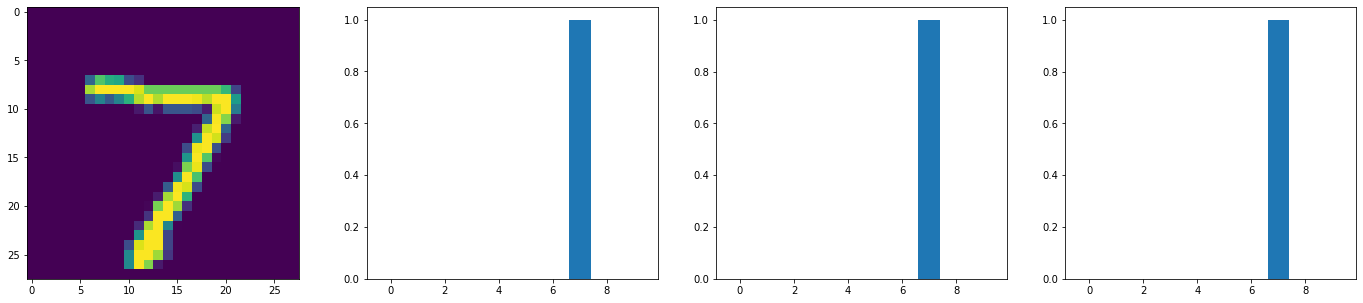

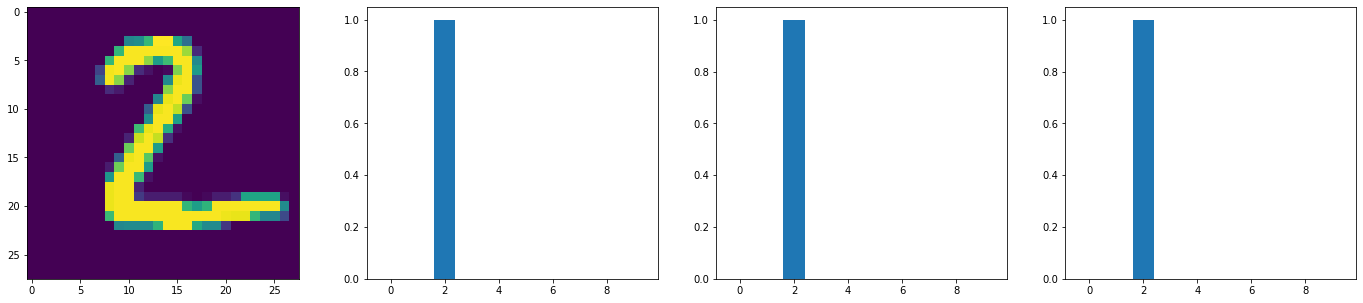

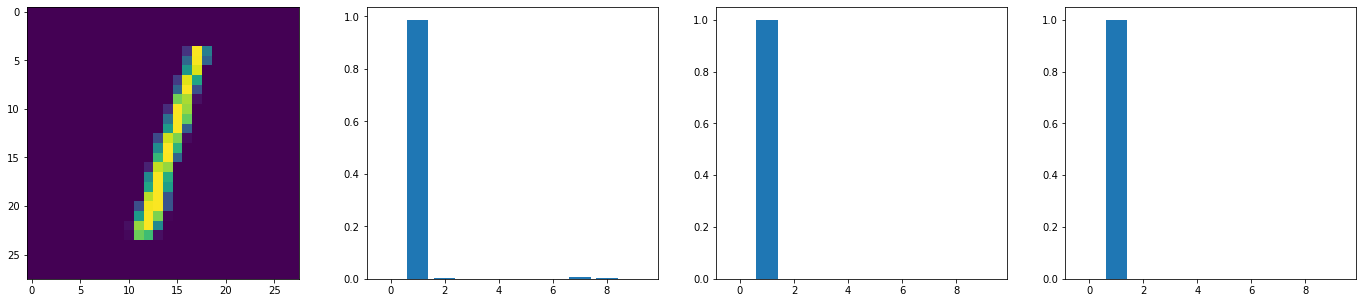

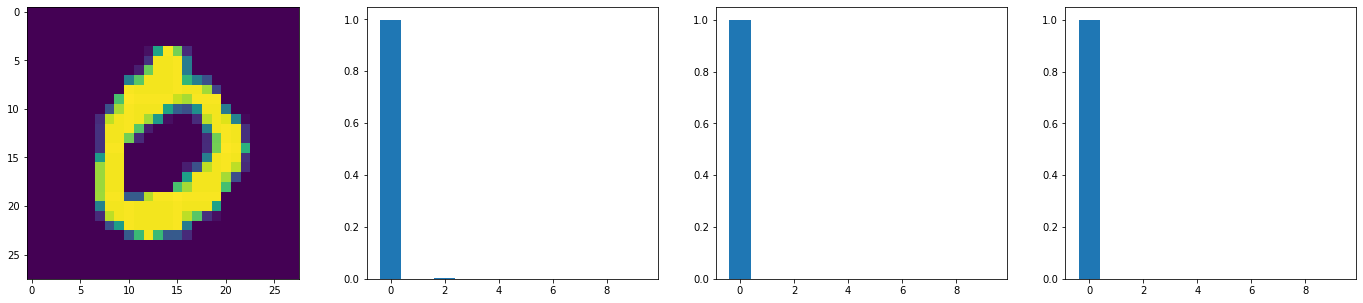

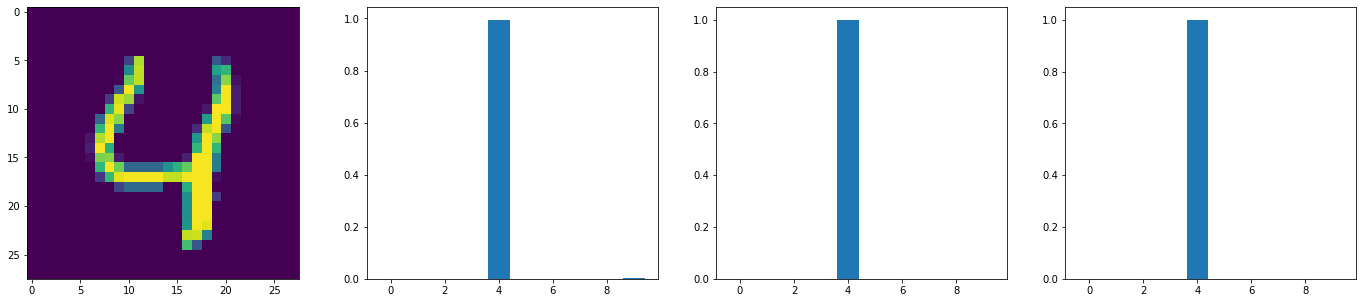

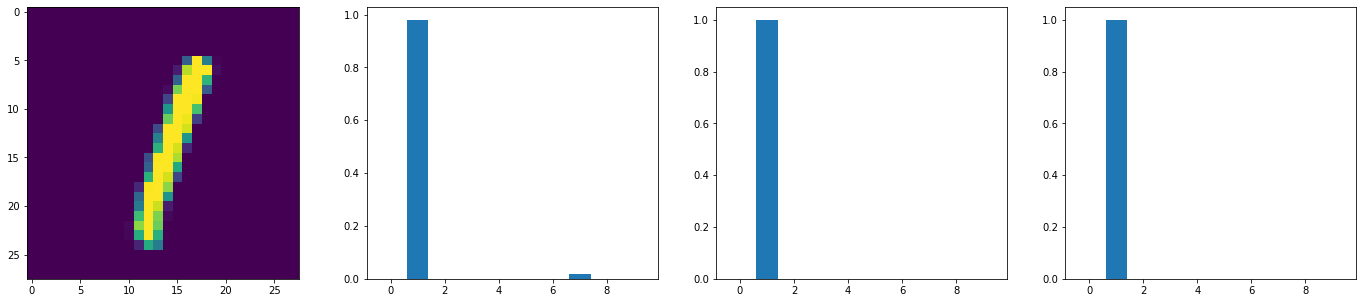

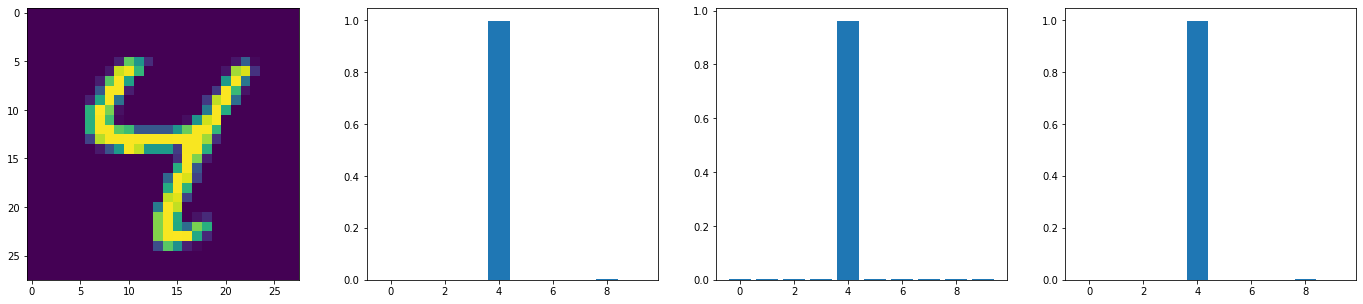

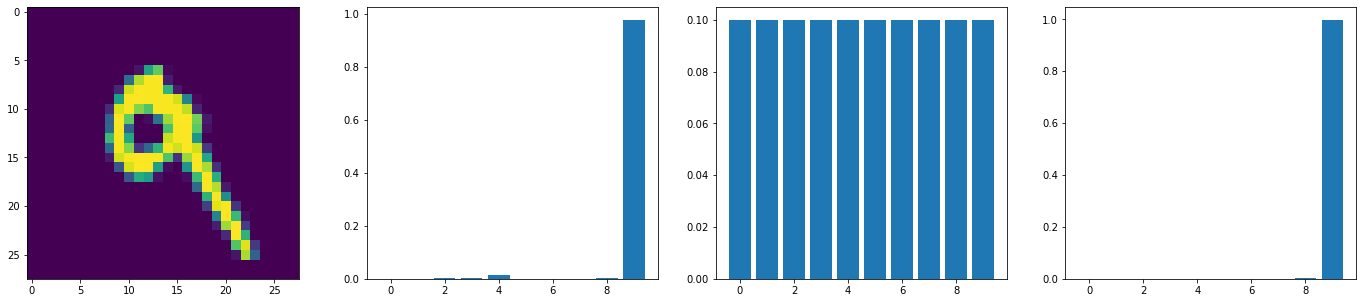

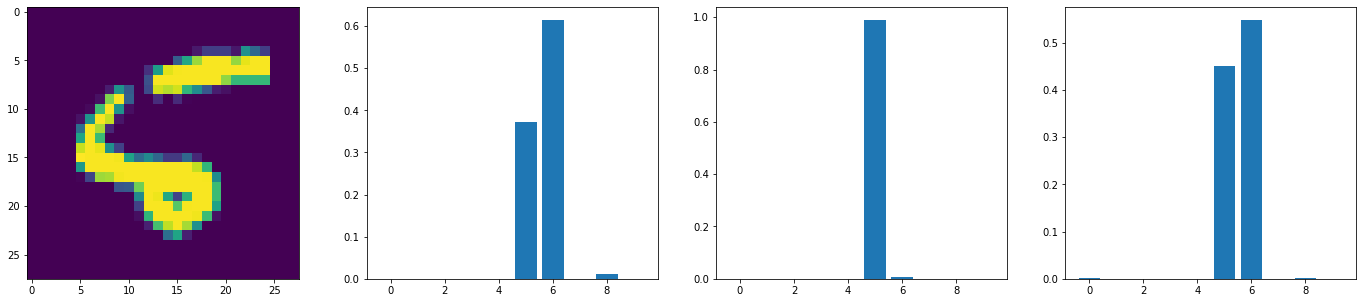

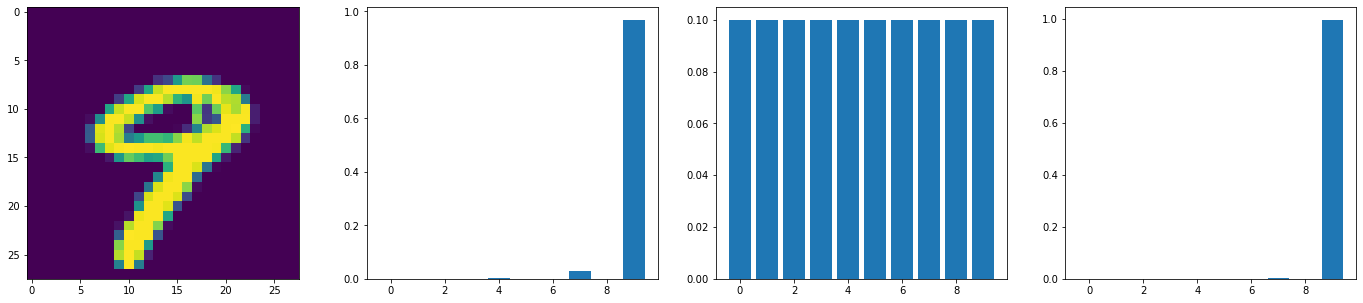

In [97]:
def plot_pred(list_of_preds,idx=0):
    num_preds = len(list_of_preds)

    plt.figure(figsize=(8*num_preds,5))
    plt.subplot(1,1+num_preds,1)
    plt.imshow(x_test[idx])
    for i,preds in enumerate(list_of_preds):
        plt.subplot(1,1+num_preds,2+i)
        plt.bar([0,1,2,3,4,5,6,7,8,9],preds[idx].numpy())

for i in range(10):
    plot_pred([pred_fdense,pred_fconv,pred_mixed],i)

# Denoising Part

### Create Noisy Data

In [76]:
sig_train = x_train
sig_test = x_test

In [77]:
def noise(imgs,sigma=.33):
    return imgs+np.random.normal(0, sigma, size=imgs.shape)
    
noisy_train = noise(sig_train)
noisy_test = noise(sig_test)

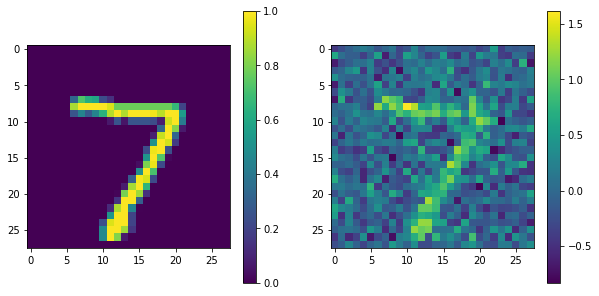

In [78]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(sig_test[0])
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(noisy_test[0])
plt.colorbar()

In [84]:
denoise_train_ds = tf.data.Dataset.from_tensor_slices(
    (noisy_train, sig_train)).shuffle(10000).batch(32)

denoise_test_ds = tf.data.Dataset.from_tensor_slices((noisy_test, sig_test)).batch(32)

### Create Network

In [85]:
class MyDenoiseModel(tf.keras.Model):
    def __init__(self):
        super(MyDenoiseModel, self).__init__()
        
        self.conv1 = tf.keras.layers.Conv2D(filters=1,  kernel_size=3, padding='same', activation='relu') 
        self.conv2 = tf.keras.layers.Conv2D(filters=10, kernel_size=3, padding='same', activation='relu') 
        self.conv3 = tf.keras.layers.Conv2D(filters=20, kernel_size=3, padding='same', activation='relu') 
        self.conv4 = tf.keras.layers.Conv2D(filters=1,  kernel_size=3, padding='same', activation='relu') 
        
        self.optimizer = tf.keras.optimizers.Adam()
        self.train_loss = tf.keras.metrics.Mean(name='train_loss')
        self.test_loss = tf.keras.metrics.Mean(name='test_loss')

    def call(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        return self.conv4(x)

#     @tf.function
    def test_step(self, images, gt):
        predictions = self(images, training=False)
        t_loss = tf.keras.losses.MSE(gt, predictions)

        self.test_loss(t_loss)
        
#     @tf.function
    def train_step(self, images, gt):
        with tf.GradientTape() as tape:
            predictions = self(images, training=True)
            loss = tf.keras.losses.MSE(gt, predictions)
        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

        self.train_loss(loss)
        
    def train(self, train_ds, test_ds, EPOCHS = 5):
        for epoch in range(EPOCHS):
            # Reset the metrics at the start of the next epoch
            self.train_loss.reset_states()
            self.test_loss.reset_states()

            for images, gt in train_ds:
                self.train_step(images, gt)

            for test_images, test_gt in test_ds:
                self.test_step(test_images, test_gt)

            print( 'Epoch %d, Loss: %.7f, Test Loss: %.7f'%(
                epoch+1, self.train_loss.result(), self.test_loss.result() ) )

### Train

In [87]:
model_denoise = MyDenoiseModel()
model_denoise.train(denoise_train_ds,denoise_test_ds,EPOCHS=2)
model_denoise.summary()

Epoch 1, Loss: 0.0082755, Test Loss: 0.0061436
Epoch 2, Loss: 0.0060026, Test Loss: 0.0058578
Model: "my_denoise_model_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_67 (Conv2D)           multiple                  10        
_________________________________________________________________
conv2d_68 (Conv2D)           multiple                  100       
_________________________________________________________________
conv2d_69 (Conv2D)           multiple                  1820      
_________________________________________________________________
conv2d_70 (Conv2D)           multiple                  181       
Total params: 2,115
Trainable params: 2,111
Non-trainable params: 4
_________________________________________________________________


### Evaluate

In [88]:
denoised = model_denoise(noisy_test, training=False)

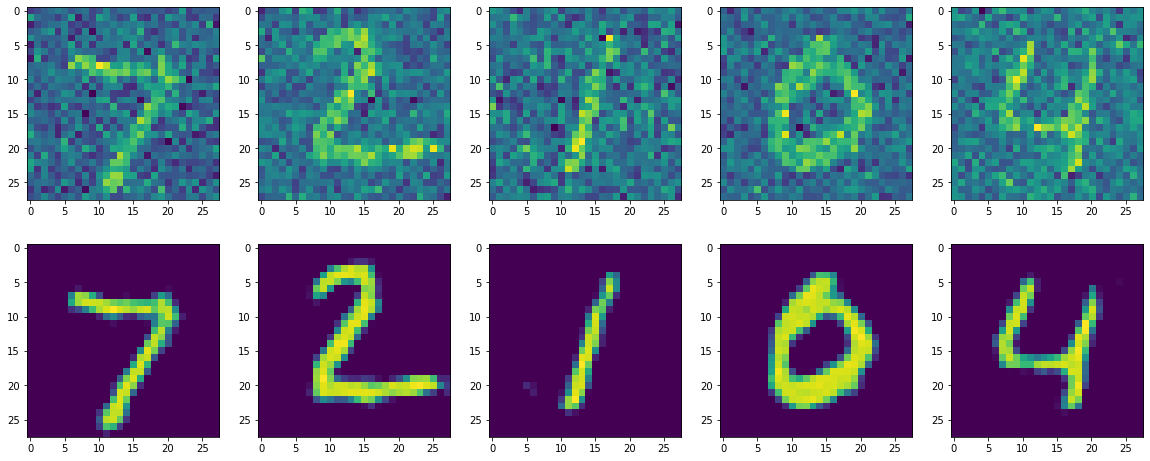

In [89]:
plt.figure(figsize=(20,8))
for i in range(5):
    plt.subplot(2,5,1+i)
    plt.imshow(noisy_test[i])
for i in range(5):
    plt.subplot(2,5,6+i)
    plt.imshow(denoised[i])